# Mosaicing

L'objectif est ici de rassembler plusieurs bouts d'images, ayant un certain recouvrement, afin de faire une seule grande image (comme pour un panorama par exemple).

In [1]:
# Import
import nbimporter
from utils import mosaicing as utils
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:

lyon = cv2.cvtColor(cv2.imread("/home/dreamexe/Documents/Epita/S8/TIFO/pansharpening/images/landsat_9/lyon/LC08_L1TP_196028_20220418_20220427_02_T1_PANSHARPENED.TIF"), cv2.COLOR_BGR2RGB)
lausanne = cv2.cvtColor(cv2.imread("/home/dreamexe/Documents/Epita/S8/TIFO/pansharpening/images/landsat_9/lausanne/LC09_L1TP_195028_20220419_20220419_02_T1_PANSHARPENED.TIF"), cv2.COLOR_BGR2RGB)

images = [lausanne, lyon]

lausanne.shape, lyon.shape

((16021, 15821, 3), (15541, 15301, 3))

Si la charge est trop lourde pour la RAM, comme pour les images pansharpnées (RGB, ~15000x15000), on utilise la cellule suivante pour effectuer le calcul sur une image downsamplée.

In [3]:
lyon_lite = cv2.resize(lyon, (lyon.shape[1] // 4, lyon.shape[0] // 4))
lausanne_lite = cv2.resize(lausanne, (lausanne.shape[1] // 4, lausanne.shape[0] // 4))

images = [lausanne_lite, lyon_lite]

lausanne_lite.shape, lyon_lite.shape

((4005, 3955, 3), (3885, 3825, 3))

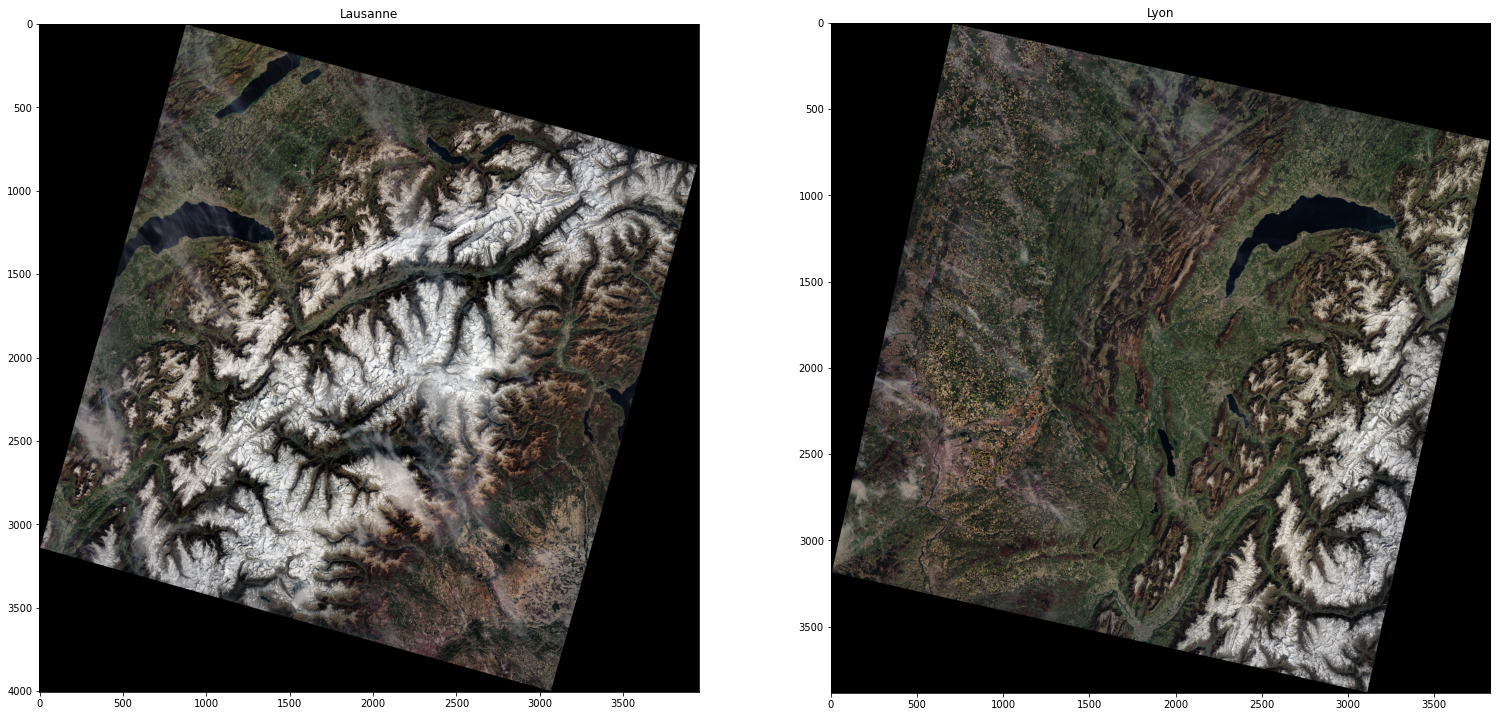

In [4]:
utils.plot_list(images, ['Lausanne', 'Lyon'])

In [5]:
"""
keypoints_detection : Trouve les keypoints sur une image donnée avec ORB (Oriented FAST and Rotated BRIEF)
img                 : L'image à traiter
return              : tuple de listes : <[keypoints], [descriptors]> issus de l'image traitée
"""

def keypoints_detection(img):
    img = utils.to_gray(img)
    orb = cv2.ORB_create(nfeatures=2000)
    kp, des = orb.detectAndCompute(img, None)

    # Plot
    output = cv2.drawKeypoints(img, kp, 0, color=(255, 0, 0), flags=cv2.DrawMatchesFlags_DRAW_RICH_KEYPOINTS)
    plt.figure(figsize = (12, 12))
    plt.imshow(output)
    plt.show()
    
    return kp,des

In [6]:
"""
Fonction issue du cours de MLRF de Joseph Chazalon.

draw_matches : Dessine les matches données entre deux images
img1         : La première image en couleurs
kpts1        : Les keypoints de la première image
img2         : La seconde image en couleurs
kpts2        : Les keypoints de la seconde image
matches      : Les matches à afficher entre les deux images
color        : Couleur dans laquelle afficher les matches, rouge par défaut
title        : Titre à donner aux graphique obtenu. Vide par défaut mais affichera toujours le nombre de matches dessinés
return       : Rien
"""

def draw_matches(img1, kpts1, img2, kpts2, matches, color=(0,0,255), title=""):
    img_matches = np.empty((max(img1.shape[0], img2.shape[0]),
                           img1.shape[1]+img2.shape[1], 
                           3), 
                           dtype=np.uint8)
    img_matches = cv2.drawMatchesKnn(img1, kpts1, img2, kpts2, 
                          matches, 
                          img_matches,
                          matchColor=color,
                          flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS|2)
    plt.figure(figsize=(20,20))
    plt.imshow(img_matches)
    plt.title(title + " - %d matches" % (len(matches),))

In [7]:
"""
match_points : Matche les points obtenus entre nos deux images
des1         : Descripteurs de la première image
des2         : Descripteurs de la seconde image
return       : Liste des matches obtenus
"""
def match_points(des1, des2):
    bf = cv2.BFMatcher_create(cv2.NORM_HAMMING)
    matches = bf.knnMatch(des1, des2, k=2)
    return matches

On veut seulement garder les matchs forts, qui ont du sens dans notre situation. Pour faire cela, on utilise **David Lowe's ratio test**. 

Son test de ratio permet d'augmenter la robustesse de l'algorithme **SIFT** (La scale-invariant feature transform (SIFT), que l'on peut traduire par « transformation de caractéristiques visuelles invariante à l'échelle », est un algorithme utilisé dans le domaine de la vision par ordinateur pour détecter et identifier les éléments similaires entre différentes images numériques).

Le but est d'exclure les points trop distincts entre eux. On exclut ces points lorsque la distance de **match** est au dessus d'un certain threshold. Ainsi, nous préservons les meilleurs matches qui doivent correspondre à la partie commune entre nos deux images.

In [8]:
"""
find_good_matches : Sélection des matches forts exclusivement
matches           : Liste de matches
return            : Liste de matches sélectionnés
"""
def find_good_matches(matches):
    good = []
    for m, n in matches:
        if m.distance <  0.9 * n.distance:
            good.append([m])
    return good

In [9]:
"""
find_homography : Calcul de la mtrice homographique
kp1             : Keypoints issus de la première image
kp2             : Keypoints issus de la seconde image
return          : La matrice homographique de 3x3
"""
def find_homography(kp1, kp2, matches):
    
    min_matches = 4
    if len(matches) <= min_matches:
        print("Not enough matches. Could not strap images")
        return []
    
    tmp = []
    for m in matches:
        tmp.append(m[0])

    src_pts = np.float32([kp1[m.queryIdx].pt for m in tmp]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in tmp]).reshape(-1, 1, 2)
    
    H,_ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)    
    return H

In [10]:
"""
strap  : Associe les deux images de base en une seule image
im1    : La première image en couleurs
im2    : La seconde image en couleurs
H      : La matrice homographique
return : L'image obtenue
"""
def strap(im1, im2, H):    
    # utils.display_img(strapped)

    width, height = ((im1.shape[1] + im2.shape[1]), im2.shape[0])

    big_im = np.zeros((height, width, 3))
    big_im[0:im2.shape[0], 0:im2.shape[1]] = im2
    big_im_mask = big_im > 0

    strapped = cv2.warpPerspective(im1, H, (width, height))

    strapped[big_im_mask] = big_im[big_im_mask]
    return strapped

In [16]:
"""
mosaicing : Fonction principale pour réunir deux images entre elles
im1       : La première image à réunir
im2       : La seconde image à réunir
return    : Une seule grande image réunissant les deux images de base
"""
def mosaicing(im1, im2):
    
    # Get descriptors and keypoints
    kp1, des1 = keypoints_detection(im1)
    kp2, des2 = keypoints_detection(im2)
    # Get matches and filter matches
    matches = match_points(des1, des2)
    good_matches = find_good_matches(matches)
    
    # Display matches
    # draw_matches(im1, kp1, im2, kp2, matches[:50], color =(0,0,255), title="50 matches over " + str(len(matches)))
    draw_matches(im1, kp1, im2, kp2, matches, color =(0,0,255), title=str(len(matches)) + " matches")
    draw_matches(im1, kp1, im2, kp2, good_matches, color =(0,0,255), title="Good matches")
    
    # Get homography matrix and merge the images
    H = find_homography(kp1, kp2, good_matches)
    merged = strap(im1, im2, H)
    
    return merged

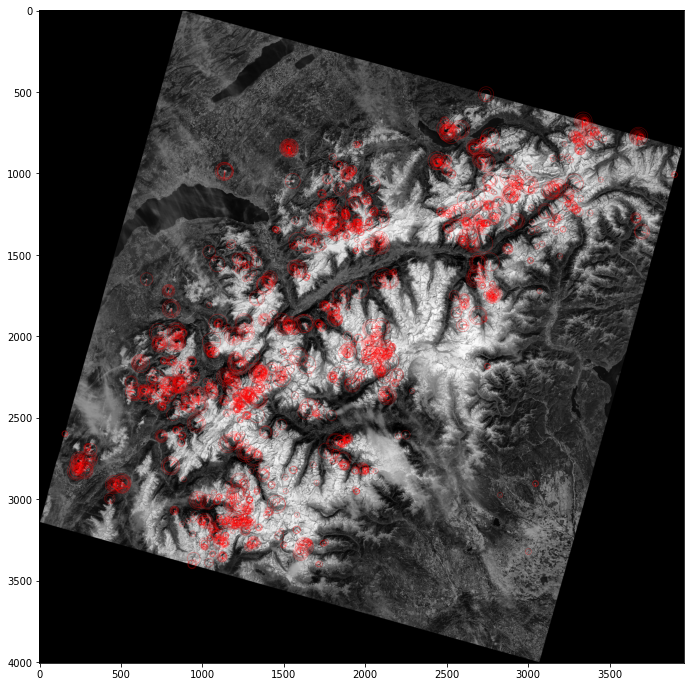

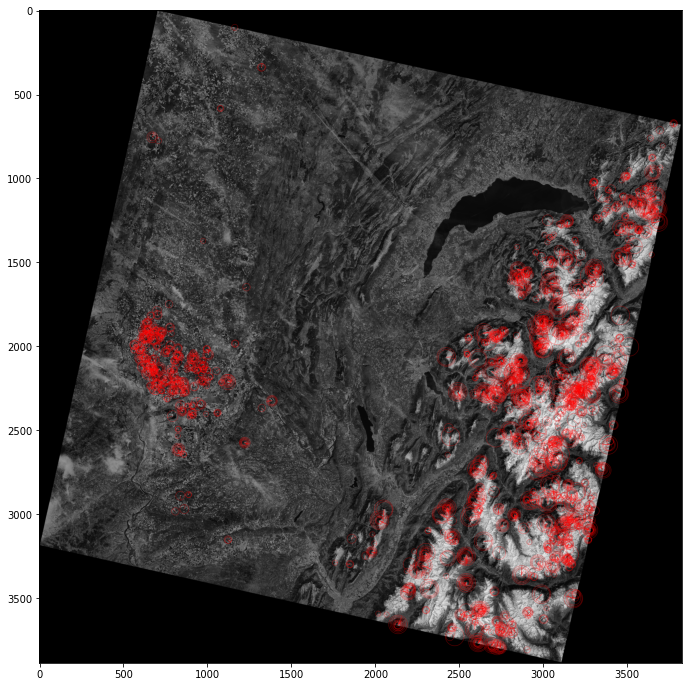

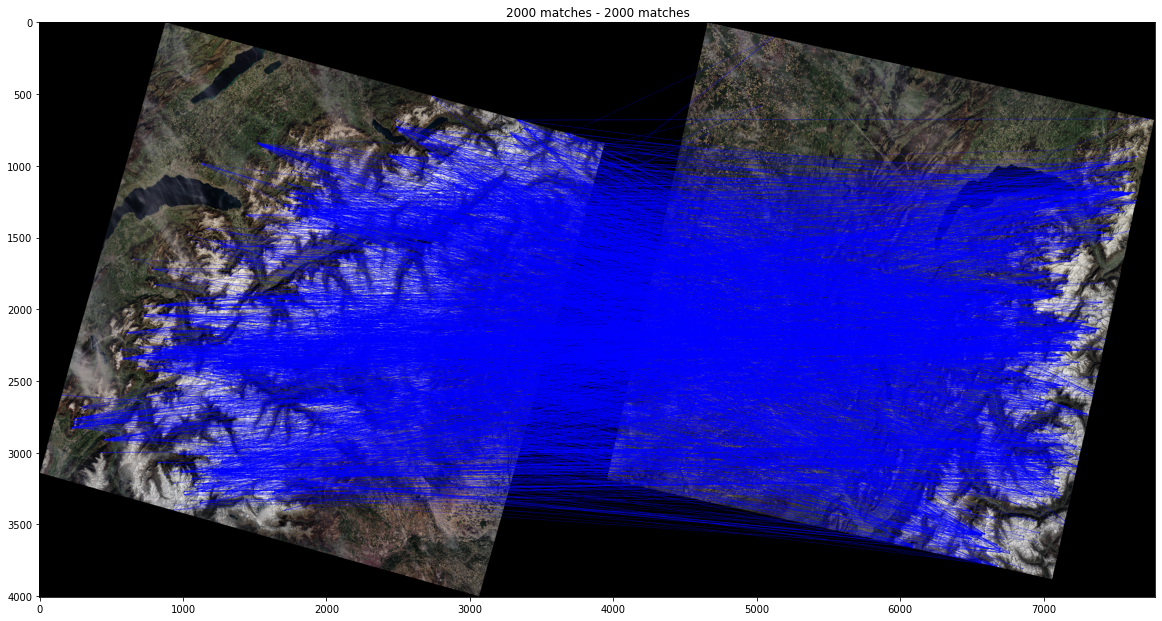

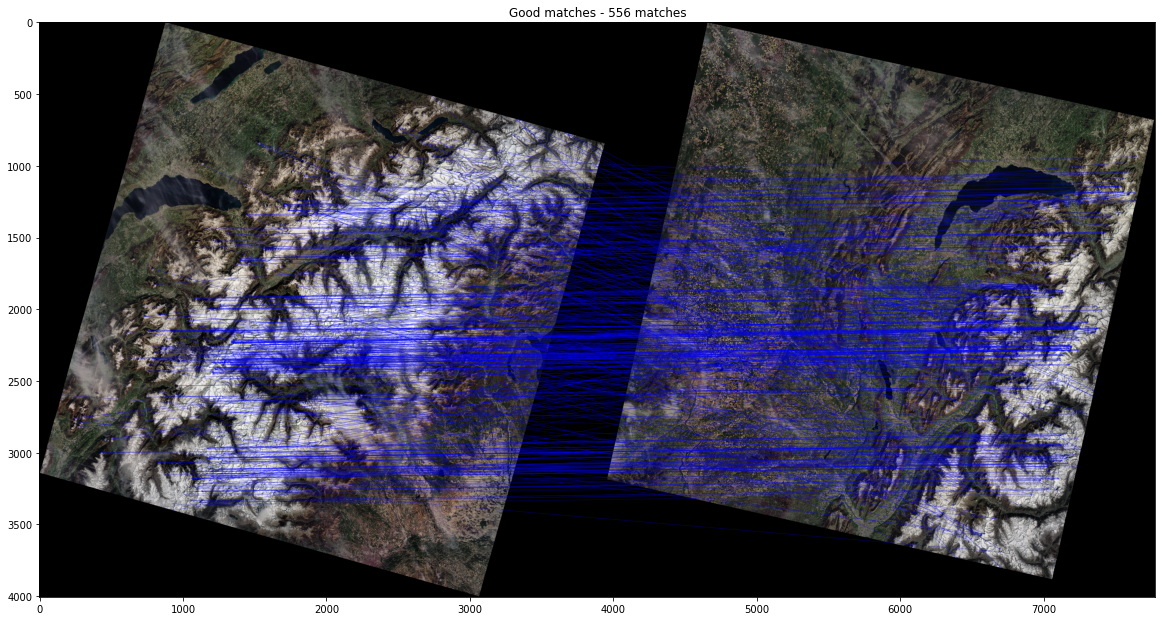

In [29]:
mosaic = mosaicing(images[0], images[1])

In [35]:
# Delete black columns
idx = np.argwhere(np.all(mosaic[..., :] == 0, axis=0))
mosaic = np.delete(mosaic, idx, axis=1)

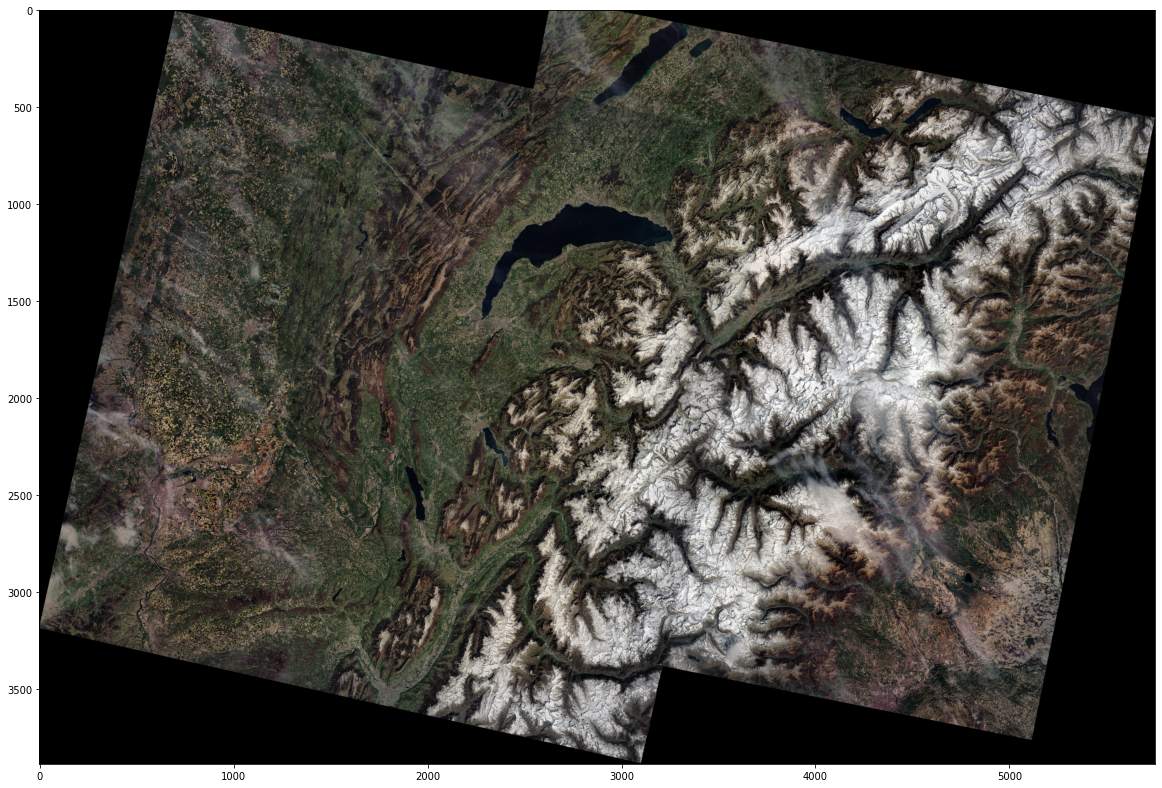

In [36]:
utils.display_img(mosaic)

In [38]:
cv2.imwrite('/home/dreamexe/Documents/Epita/S8/TIFO/pansharpening/images/results/mosaic_color_hd.png', cv2.cvtColor(mosaic, cv2.COLOR_RGB2BGR))

True